# Pixel Art Generation with SLIC algorihtm

link for dataset: https://huggingface.co/datasets/qwertyforce/scenery_watermarks/viewer

## The SLIC algorithm implementation

Iteration 1: Center shift = 79.91804036163683
Iteration 2: Center shift = 29.770905657813962
Iteration 3: Center shift = 21.629327704593877
Iteration 4: Center shift = 18.244029855956875
Iteration 5: Center shift = 14.60604112490264
Iteration 6: Center shift = 11.590133317215276
Iteration 7: Center shift = 11.17029411178162
Iteration 8: Center shift = 12.057732315518578
Iteration 9: Center shift = 14.373073507185412
Iteration 10: Center shift = 15.713093379112637
Iteration 11: Center shift = 14.024461703084595
Iteration 12: Center shift = 11.047005885498837
Iteration 13: Center shift = 8.326469904794752
Iteration 14: Center shift = 6.045772925588676
Iteration 15: Center shift = 4.61174798135624
Iteration 16: Center shift = 3.792968856909379
Iteration 17: Center shift = 3.3715325952989583
Iteration 18: Center shift = 2.955993322098819
Iteration 19: Center shift = 2.6487161752559536
Iteration 20: Center shift = 2.2548963657840524
Iteration 21: Center shift = 2.3151065432631706
Iteration 

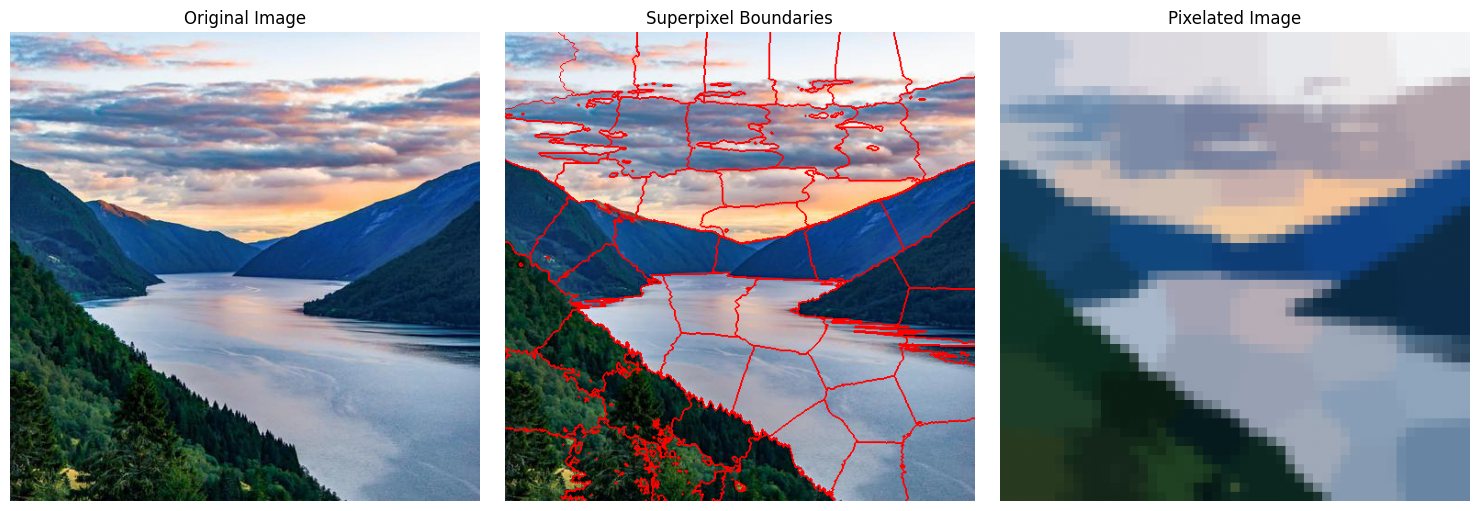

Pixelated image saved to output/5_50_30_30_0.1.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
from skimage.segmentation import mark_boundaries
from collections import deque
import os

def slic(img, num_superpixels=400, m=10, max_iter=10):
    H, W, _ = img.shape
    lab_img = color.rgb2lab(img)
    l, a, b = lab_img[:,:,0], lab_img[:,:,1], lab_img[:,:,2]

    S = int(np.sqrt(H * W / num_superpixels))  # Grid interval
    centers = []
    for y in range(S//2, H, S):
        for x in range(S//2, W, S):
            centers.append((y, x))
    centers = np.array(centers)
    K = len(centers)

    # Initialize cluster centers with local gradient minimum
    cluster_centers = []
    for cy, cx in centers:
        min_grad = float('inf')
        local_center = (cy, cx)
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                yy, xx = cy + dy, cx + dx
                if 0 <= yy < H-1 and 0 <= xx < W-1:
                    grad = (l[yy, xx+1] - l[yy, xx])**2 + (l[yy+1, xx] - l[yy, xx])**2
                    if grad < min_grad:
                        min_grad = grad
                        local_center = (yy, xx)
        ly, lx = local_center
        cluster_centers.append([l[ly, lx], a[ly, lx], b[ly, lx], float(lx), float(ly)])
    cluster_centers = np.array(cluster_centers)

    labels = -1 * np.ones((H, W), dtype=np.int32)
    dist_map = np.full((H, W), np.inf)

    for it in range(max_iter):
        dist_map.fill(np.inf)
        
        for k, center in enumerate(cluster_centers):
            l_c, a_c, b_c, x_c, y_c = center
            y_min = max(int(y_c - 2*S), 0)
            y_max = min(int(y_c + 2*S), H)
            x_min = max(int(x_c - 2*S), 0)
            x_max = min(int(x_c + 2*S), W)

            region_l = l[y_min:y_max, x_min:x_max]
            region_a = a[y_min:y_max, x_min:x_max]
            region_b = b[y_min:y_max, x_min:x_max]
            yy, xx = np.indices(region_l.shape)
            yy += y_min
            xx += x_min

            dc = np.sqrt((region_l - l_c)**2 + (region_a - a_c)**2 + (region_b - b_c)**2)
            ds = np.sqrt((xx - x_c)**2 + (yy - y_c)**2)
            D = np.sqrt(dc**2 + ( (ds / S)**2 ) * (m**2))

            mask = D < dist_map[y_min:y_max, x_min:x_max]
            dist_map[y_min:y_max, x_min:x_max][mask] = D[mask]
            labels[y_min:y_max, x_min:x_max][mask] = k

        # Update cluster centers
        new_centers = np.zeros_like(cluster_centers)
        count = np.zeros(K)
        for y in range(H):
            for x in range(W):
                label = labels[y, x]
                if label != -1:
                    new_centers[label, 0] += l[y, x]
                    new_centers[label, 1] += a[y, x]
                    new_centers[label, 2] += b[y, x]
                    new_centers[label, 3] += x
                    new_centers[label, 4] += y
                    count[label] += 1

        # Avoid division by zero
        count[count == 0] = 1
        new_centers /= count[:, np.newaxis]

        # Check for convergence
        diff = np.linalg.norm(cluster_centers - new_centers)
        cluster_centers = new_centers
        print(f"Iteration {it+1}: Center shift = {diff}")
        if diff < 1e-3:
            print(f"Converged at iteration {it+1}")
            break

    labels = enforce_connectivity(labels)
    return labels

def enforce_connectivity(labels):
    H, W = labels.shape
    new_labels = -1 * np.ones_like(labels)
    label_id = 0
    directions = [(-1,0), (1,0), (0,-1), (0,1)]

    for y in range(H):
        for x in range(W):
            if new_labels[y, x] == -1:
                old_label = labels[y, x]
                queue = deque()
                queue.append((y, x))
                new_labels[y, x] = label_id

                while queue:
                    yy, xx = queue.popleft()
                    for dy, dx in directions:
                        ny, nx = yy + dy, xx + dx
                        if 0 <= ny < H and 0 <= nx < W:
                            if new_labels[ny, nx] == -1 and labels[ny, nx] == old_label:
                                new_labels[ny, nx] = label_id
                                queue.append((ny, nx))
                label_id += 1
    return new_labels

def apply_superpixel_pixelation(image, labels):
    pixelated_image = np.zeros_like(image)
    for label in np.unique(labels):
        mask = labels == label
        if np.any(mask):
            pixelated_image[mask] = image[mask].mean(axis=0)
    return pixelated_image

def main():
    image_index = 5  
    img_path = f'dataset/{image_index}.jpg'

    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return

    image = Image.open(img_path).convert('RGB')
    image = np.array(image) / 255.0  # Normalize to [0, 1]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # SLIC Parameters
    num_superpixels = 50
    m = 30
    max_iter = 30
    pixel_scale = 0.1

    labels = slic(image, num_superpixels=num_superpixels, m=m, max_iter=max_iter)
    print("SLIC segmentation completed.")
    boundary_image = mark_boundaries(image, labels, color=(1, 0, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(boundary_image)
    plt.title('Superpixel Boundaries')
    plt.axis('off')

    pixelated = apply_superpixel_pixelation(image, labels)
    if pixel_scale < 1.0:
        H, W = pixelated.shape[:2]
        small_H, small_W = int(H * pixel_scale), int(W * pixel_scale)
        small_img = Image.fromarray((pixelated * 255).astype(np.uint8)).resize((small_W, small_H), Image.BILINEAR)
        final_img = small_img.resize((W, H), Image.NEAREST)
        final_img = np.array(final_img) / 255.0
    else:
        final_img = pixelated

    plt.subplot(1, 3, 3)
    plt.imshow(final_img)
    plt.title('Pixelated Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    output_image = Image.fromarray((final_img * 255).astype(np.uint8))
    output_path = f'{output_dir}/{image_index}_{num_superpixels}_{m}_{max_iter}_{pixel_scale}.png'
    output_image.save(output_path)
    print(f"Pixelated image saved to {output_path}")

if __name__ == '__main__':
    main()


## Change Superpixel Number

Iteration 1: Center shift = 102.03719921527896
Iteration 2: Center shift = 48.48808990631623
Iteration 3: Center shift = 27.7450922243089
Iteration 4: Center shift = 22.2184235764922
Iteration 5: Center shift = 20.022953554887092
Iteration 6: Center shift = 17.65046072259861
Iteration 7: Center shift = 16.2798671318295
Iteration 8: Center shift = 13.863585308324948
Iteration 9: Center shift = 11.862742885079737
Iteration 10: Center shift = 10.521488979098974
Iteration 11: Center shift = 9.869073919463256
Iteration 12: Center shift = 10.252959299729161
Iteration 13: Center shift = 10.774533574341142
Iteration 14: Center shift = 12.09453558788645
Iteration 15: Center shift = 10.110863216394723
Iteration 16: Center shift = 7.804749419616107
Iteration 17: Center shift = 6.97543842448298
Iteration 18: Center shift = 5.549232735337422
Iteration 19: Center shift = 4.592243055610616
Iteration 20: Center shift = 3.942422771376633
Iteration 21: Center shift = 3.115583097001499
Iteration 22: Cent

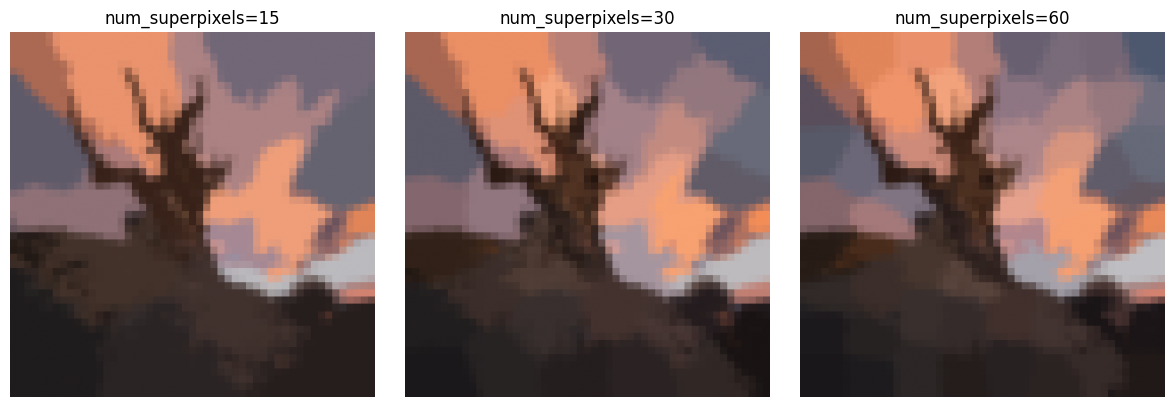

In [ ]:
def plot_varying_num_superpixels(image, num_superpixels_values, fixed_compactness, fixed_pixel_scale, max_iter):
    plt.figure(figsize=(12, 4))
    for idx, num_sp in enumerate(num_superpixels_values):
        labels = slic(image, num_superpixels=num_sp, m=fixed_compactness, max_iter=max_iter)
        pixelated_image = apply_superpixel_pixelation(image, labels)
        if fixed_pixel_scale < 1.0:
            H, W = pixelated_image.shape[:2]
            small_H = int(H * fixed_pixel_scale)
            small_W = int(W * fixed_pixel_scale)
            small_img = Image.fromarray((pixelated_image * 255).astype(np.uint8)).resize((small_W, small_H), Image.BILINEAR)
            final_img = small_img.resize((W, H), Image.NEAREST)
            final_img = np.array(final_img) / 255.0
        else:
            final_img = pixelated_image

        plt.subplot(1, 3, idx + 1)
        plt.imshow(final_img)
        plt.title(f'num_superpixels={num_sp}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Parameters
image_path = "dataset/4.jpg"
image = np.array(Image.open(image_path).convert('RGB')) / 255.0
num_superpixels_values = [15, 30, 60] # Modify this list to test different number of super-pixel values
fixed_compactness = 20
fixed_pixel_scale = 0.1
max_iter = 30

plot_varying_num_superpixels(image, num_superpixels_values, fixed_compactness, fixed_pixel_scale, max_iter)


## Change Compactness

End the 1 iterwith diff: 331.6613413908188
End the 2 iterwith diff: 140.39228520928103
End the 3 iterwith diff: 85.92100333417135
End the 4 iterwith diff: 75.03784307063206
End the 5 iterwith diff: 46.64811515220208
End the 6 iterwith diff: 38.579099455697175
End the 7 iterwith diff: 38.99287046192677
End the 8 iterwith diff: 49.16710348366171
End the 9 iterwith diff: 22.42055418406912
End the 10 iterwith diff: 15.707706180490694
End the 11 iterwith diff: 14.955909874370303
End the 12 iterwith diff: 16.721537059421767
End the 13 iterwith diff: 22.76329958358666
End the 14 iterwith diff: 25.246709206621443
End the 15 iterwith diff: 27.375137707991367
End the 16 iterwith diff: 24.085019126561033
End the 17 iterwith diff: 25.617717711346643
End the 18 iterwith diff: 27.137087603814784
End the 19 iterwith diff: 34.43875508127671
End the 20 iterwith diff: 33.74602097587775
End the 21 iterwith diff: 21.164752568457793
End the 22 iterwith diff: 12.21928527147094
End the 23 iterwith diff: 11.0

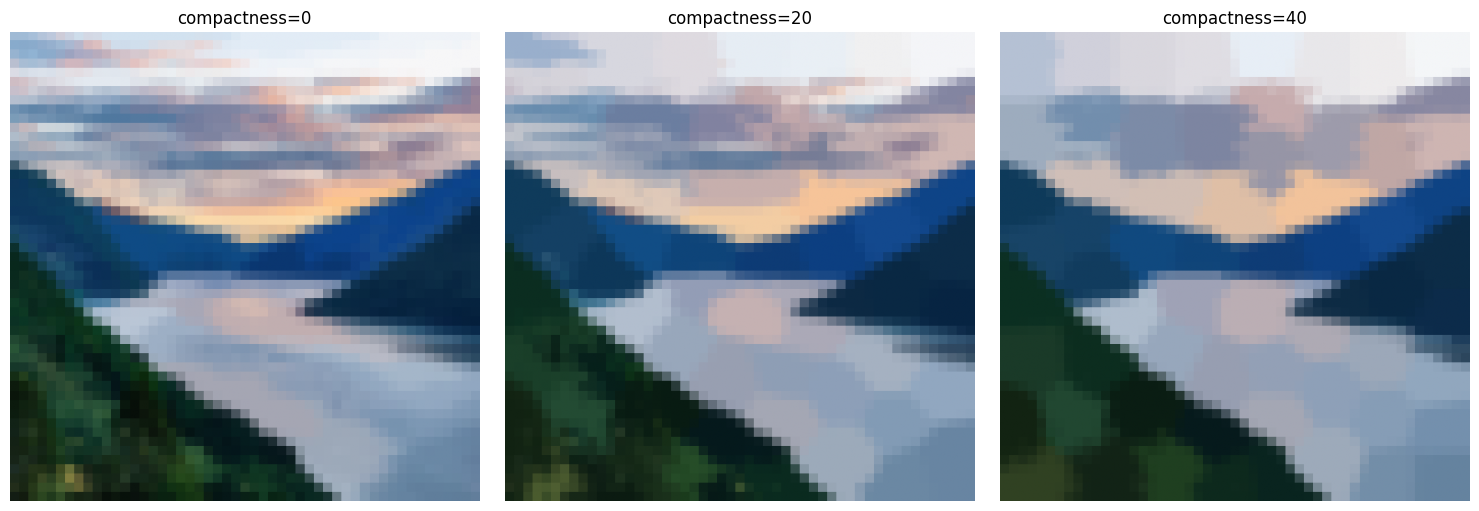

In [ ]:
def plot_varying_compactness(image, compactness_values, fixed_num_superpixels, fixed_pixel_scale, max_iter):
    plt.figure(figsize=(15, 5))
    for idx, comp in enumerate(compactness_values):
        labels = slic(image, num_superpixels=fixed_num_superpixels, m=comp, max_iter=max_iter)
        pixelated_image = apply_superpixel_pixelation(image, labels)
        if fixed_pixel_scale < 1.0:
            H, W = pixelated_image.shape[:2]
            small_H = int(H * fixed_pixel_scale)
            small_W = int(W * fixed_pixel_scale)
            small_img = Image.fromarray((pixelated_image * 255).astype(np.uint8)).resize((small_W, small_H), Image.BILINEAR)
            final_img = small_img.resize((W, H), Image.NEAREST)
            final_img = np.array(final_img) / 255.0
        else:
            final_img = pixelated_image

        plt.subplot(1, 3, idx + 1)
        plt.imshow(final_img)
        plt.title(f'compactness={comp}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
image_path = "dataset/5.jpg"
image = np.array(Image.open(image_path).convert('RGB')) / 255.0
compactness_values = [0, 20, 40] # Modify this list to test different compactness values
fixed_num_superpixels = 60
fixed_pixel_scale = 0.1
max_iter = 30
plot_varying_compactness(image, compactness_values, fixed_num_superpixels, fixed_pixel_scale, max_iter)


## Change pixel scale

Iteration 1 with diff: 143.55069934686117
Iteration 2 with diff: 51.8681465006041
Iteration 3 with diff: 35.131694820541
Iteration 4 with diff: 27.544027658040896
Iteration 5 with diff: 22.149679586236854
Iteration 6 with diff: 18.188875878810972
Iteration 7 with diff: 15.941435634910968
Iteration 8 with diff: 14.784372756070303
Iteration 9 with diff: 13.81119716823771
Iteration 10 with diff: 14.526934263927036
Iteration 11 with diff: 14.770566557668126
Iteration 12 with diff: 11.621107175825419
Iteration 13 with diff: 10.316087768731443
Iteration 14 with diff: 9.542268455385742
Iteration 15 with diff: 8.992946837159472
Iteration 16 with diff: 9.06358099883534
Iteration 17 with diff: 8.288931107726622
Iteration 18 with diff: 7.827926424611963
Iteration 19 with diff: 7.474094330147779
Iteration 20 with diff: 7.012791700022085
Iteration 21 with diff: 6.108163408754681
Iteration 22 with diff: 5.749770239822765
Iteration 23 with diff: 5.772052868588423
Iteration 24 with diff: 6.10706733194

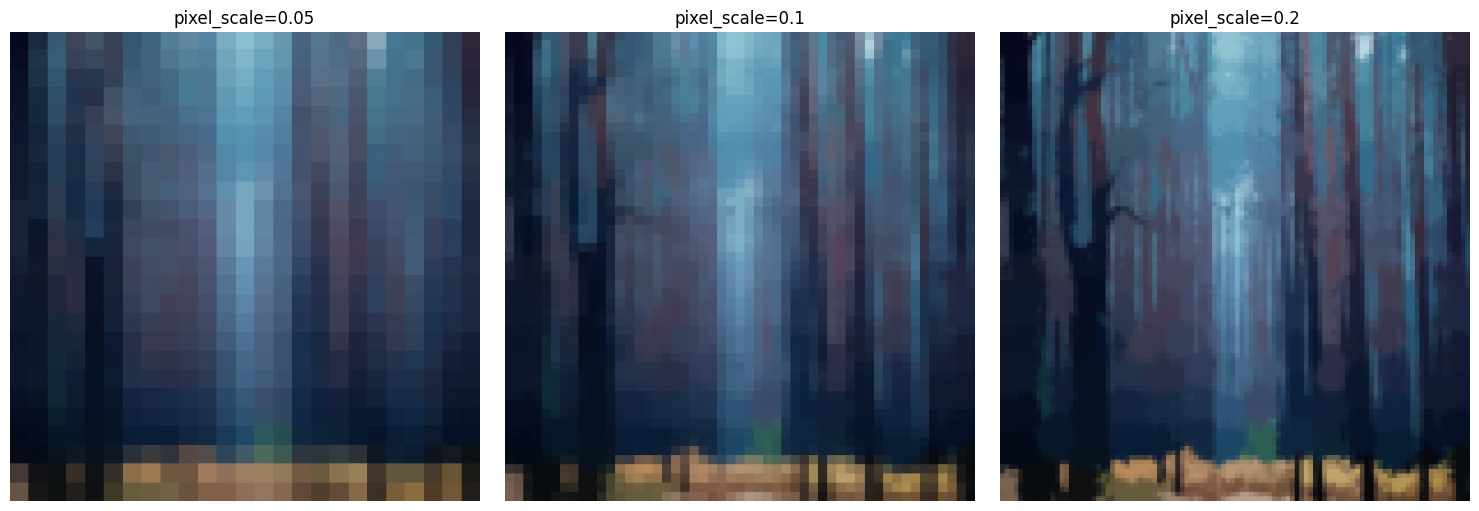

In [ ]:
def plot_varying_pixel_scale(image, pixel_scale_values, fixed_num_superpixels, fixed_compactness, max_iter):
    plt.figure(figsize=(15, 5))
    for idx, scale in enumerate(pixel_scale_values):
        labels = slic(image, num_superpixels=fixed_num_superpixels, m=fixed_compactness, max_iter=max_iter)
        pixelated_image = apply_superpixel_pixelation(image, labels)
        if scale < 1.0:
            H, W = pixelated_image.shape[:2]
            small_H = int(H * scale)
            small_W = int(W * scale)
            small_img = Image.fromarray((pixelated_image * 255).astype(np.uint8)).resize((small_W, small_H), Image.BILINEAR)
            final_img = small_img.resize((W, H), Image.NEAREST)
            final_img = np.array(final_img) / 255.0
        else:
            final_img = pixelated_image

        plt.subplot(1, 3, idx + 1)
        plt.imshow(final_img)
        plt.title(f'pixel_scale={scale}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


image_path = "dataset/1.jpg"
image = np.array(Image.open(image_path).convert('RGB')) / 255.0
fixed_num_superpixels = 200
max_iter = 30
fixed_compactness = 20
pixel_scale_values = [0.05, 0.1, 0.2] ## Modify this list to test different pixel scale values
plot_varying_pixel_scale(image, pixel_scale_values, fixed_num_superpixels, fixed_compactness, max_iter)
